# Coupled flow-flexure ice shelf model
This notebook couples a slightly modified SSA [(MacAyeal et al., 2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3) with the Kirchhoff plate equations, allowing the approach of a steady-state ice shelf profile under both horizontal viscous flow and vertical elastic deflection. Equations are solved using Firedrake and [icepack](https://github.com/icepack/icepack). Beginning with a shelf in isostatic equilibrium with seawater, the workflow is as follows:

## Workflow

1) **Solve the SSA to obtain a velocity field**
    - this is the modified version from Equation 44 in MacAyeal et al. 
    - see also my [modified SSA notebook](https://github.com/chrismiele/weird_flex/blob/main/modified_SSA_firedrake.ipynb)<br>
    <br>
2) **Adjust the surface elevation and basal elevation via dynamic thinning only**
    - adjust shelf geometry under *zero surface mass balance* (SMB will be applied in Step 4)
    - dynamically thin the submarine and subaerial parts of the shelf separately
    - this allows us to track the dynamic evolution of surface and basal elevation without assuming equilibrium <br>
    <br>
3) **Solve the Kirchhoff equations to flex the shelf**
    - load relates to surface mass balance and velocity field as outlined in Eq. 57 of MacAyeal et al.
    - see also my [Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/kirchhoff_plate.ipynb)
    - in this step, we obtain the vertical deflection η <br>
    <br>
4) **Adjust geometry and return to (1)**
    - now use SMB and η to modify surface elevation, via ```s = s + SMB + η```
    - with no basal mass balance component, ```b = b + η```

## Imports

In [1]:
from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```. Deflection will be solved over Argyris elements of order 5, and velocity will be solved over CG elements of order 2. 

In [2]:
nx, ny = 50, 25 #number of elements in x, y
Lx, Ly = 10000, 5000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection
w = TestFunction(Q1)
ddη = grad(grad(η)) 
ddw = grad(grad(w))
Δη = div(grad(η)) 
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import ice_density as ρ_I, water_density as ρ_W, gravity as G #note icepack's units on these
ρ_i = 917 #ice density value consistent with icepack's, but in kg/m^3
ρ_w = 1024 #water density consistent with icepack, but in kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
E = 1e9 #Young's Modulus in Pascals
μ = 1/3 #Poisson's Ratio
λ_1 = E/(1 + μ) #convenient shorthand variable
λ_2 = E/(1 + μ)*μ/(1 - μ) #convenient shorthand variable
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law
ν = 1/2*A**(-1/3) #ice viscosity (note the symbol Greek symbol ν)

H_gl = 600 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. 

In [4]:
def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)

def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

def deviatoric_stress(**kwargs): #and also define the deviatoric stress tensor
    n = 3
    e = itemgetter('strain_rate')(kwargs)
    e_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    e_e = icepack.models.viscosity._effective_strain_rate(e, e_min)
    ν = 1/2*A**(-1/n)*e_e**(1/n-1)
    return 2*ν*e

## Set up the solver

We'll apply the flow-flexure model to the simplest case of a shelf in longitudinal extension. This is achieved by assigning the lateral boundaries in the flow solver to be ```side_wall_ids``` with friction coefficient zero. 

To provide a load for the flexure solver, surface mass balance is chosen to melt out a lake in the shape of a Gaussian curve (see figure below). 

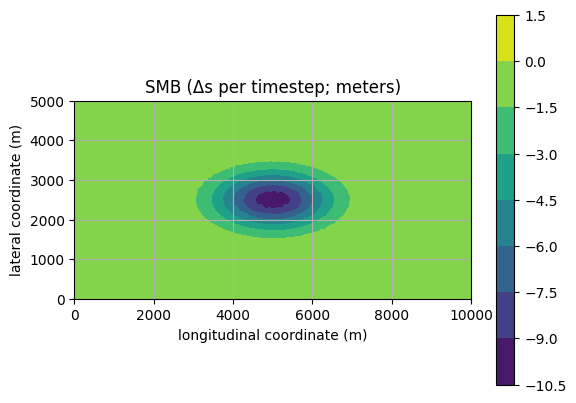

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

dt = 0.5 #length of timestep in years
num_timesteps = 40

##################################
##################################
### parameters for flow solver ###
##################################
##################################

dirichlet_ids = [1] #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
side_wall_ids = [3, 4]
ice_front_ids = [2]

ux_gl = 500 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

C0 = Constant(0.0) #coefficient of sidewall friction

model = icepack.models.IceShelf(gravity = gravity2, terminus = terminus2, #model is icepack's SSA, but with our own physics
                           side_friction = icepack.models.friction.side_friction)

solver = icepack.solvers.FlowSolver(model, dirichlet_ids = dirichlet_ids, 
                                    side_wall_ids = side_wall_ids, ice_front_ids = ice_front_ids)

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method
smb_x = 20*exp(-1/2*((x - Lx/2)/1000)**2) #impose some surface mass balance to load the shelf
smb_y = exp(-1/2*((y - Ly/2)/500)**2) #we'll melt out a lake at the center of the shelf...
SMB = project(-smb_x*smb_y*dt, Q1) #...in the shape of a 3D gaussian curve (see figure below)

#####################################
#####################################
### plot the surface mass balance ###
#####################################
#####################################

fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.title('SMB (Δs per timestep; meters)')
smb_plot = tricontourf(SMB, axes=ax)
plt.colorbar(smb_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

## Iteratively solve the flow-flexure problem

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:35<00:00,  2.39s/it]


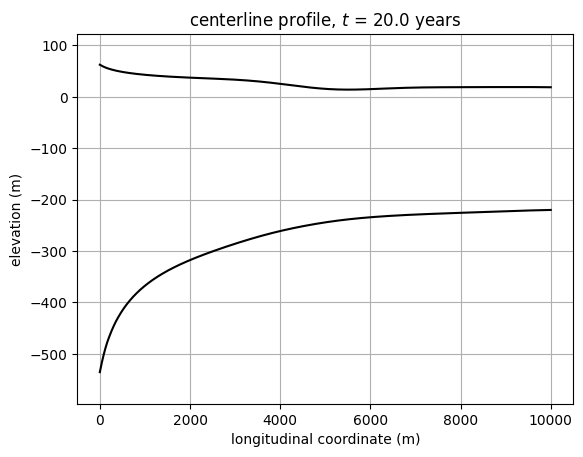

In [6]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize
os.chdir('/home/sermilik/firedrake_stuff/figures/flow_flexure') #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles

#plot and save the initial surface/basal profiles along the line "X"
s_profile = np.array(s.at(X, tolerance = 1e-10))
b_profile = np.array(b.at(X, tolerance = 1e-10))
plt.figure()
plt.title('centerline profile, $t$ = 0 years')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(int(-ϱ*H_gl - H_gl/10), int((1 - ϱ)*H_gl + H_gl/10))
plt.plot(s_profile, color='k')
plt.plot(b_profile, color='k')
plt.grid()
plt.savefig('iteration_0')
plt.close()

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = solver.diagnostic_solve(velocity = u, side_friction = C0, thickness = H, base = b, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = solver.prognostic_solve(dt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = Constant((1 - ϱ)*H_gl), accumulation = Constant(0))
    
    b = solver.prognostic_solve(dt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = Constant(-ϱ*H_gl), accumulation = Constant(0))

    s_ = project(s, Q1) #project surface elevation over Argyris elements
    b_ = project(b, Q1) #and basal elevation
    H_ = project(s_ - b_, Q1) #and total thickness
    
    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s_ + SMB + η - (1 - ϱ)*H_ #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    #additionally force flexure with the velocity field, as in Eq. 57e 
    ux, uy = project(u[0], Q1), project(u[1], Q1) #velocity compenents
    f += H_*(4*ν*grad(ux)[0] + 2*ν*grad(uy)[0] - 1/2*ρ_i*g*H_)*ddη[0, 0] #Eq. 57e: ice shelf flow contribution 
    f += H_*(ν*grad(ux)[1] + ν*grad(uy)[0])*ddη[0, 1] #Eq. 57e continued
    f += H_*(2*ν*grad(ux)[0] + 4*ν*grad(uy)[1] - 1/2*ρ_i*g*H_)*ddη[1, 1] #Eq. 57e continued

    L = (λ_1*(H_**3)/12*inner(ddη, ddw))*dx + λ_2*(H_**3)/12*Δη*Δw*dx - f*w*dx #the flexure equation
    L += 0.5*α**2*(η*w)*ds(1) #constrain η = 0 on the upstream boundary 1 via the penalty method
    L += 0.5*α**2*(η*w)*ds(2) #η = 0 on the downstream boundary via the penalty method

    solve(L == 0, η)

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η, Q2) #b is modified by the deflection
    s = project(s + SMB + η, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #in either case, H = s - b

    
    #################################################
    #################################################
    ### make sure nothing has gone horribly wrong ###
    #################################################
    #################################################
    
    #if we've imposed too much surface melt, the surface may dip below the waterline
    #this breaks the mass conservation equations
    
    s_values = s.vector().get_local()
    if not np.all(s_values > 0): #if s < 0 anywhere:
        print('the surface went underwater! that sucks!')
        break
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(b.at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('centerline profile, $t$ = {:.1f} years'.format(step*dt + dt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.ylim(int(-ϱ*H_gl) - H_gl/10, int((1 - ϱ)*H_gl + H_gl/10))
    plt.plot(s_profile, color='k')
    plt.plot(b_profile, color='k')
    plt.grid()
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

## Plot results

Notice that the elastic strength of the ice is sufficient to hold the shelf several meters out of isostatic equilibrium locally, but, on average, the shelf is within a few centimeters of flotation.

bulk height above buoyancy: 0.076 meters


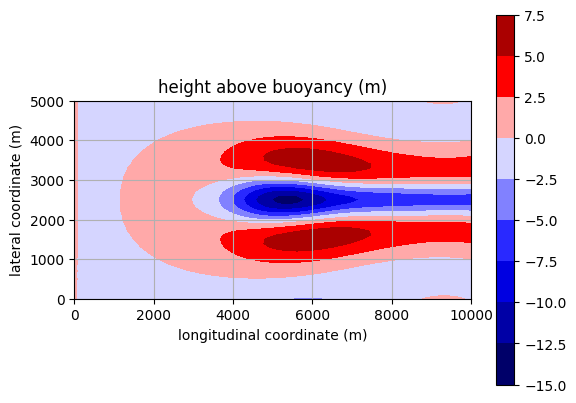

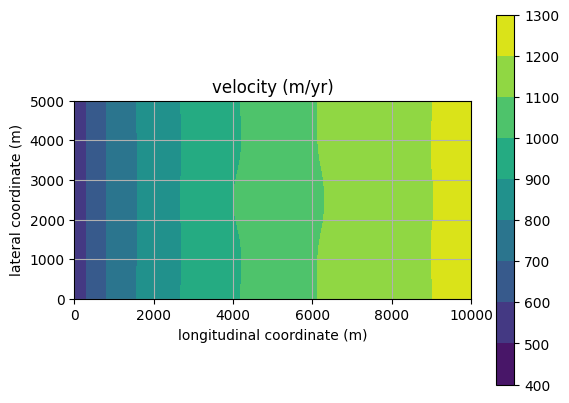

In [7]:
h_ab = project(h_ab, Q2) #local height above buoyancy
mean_hab = np.mean(h_ab.vector().get_local()) #calculate the bulk height above buoyancy across the entire shelf
print('bulk height above buoyancy: {:.3f} meters'.format(mean_hab))

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('height above buoyancy (m)')
norm = colors.TwoSlopeNorm(vcenter = 0)
elev_plot = tricontourf(h_ab, axes=ax, norm = norm, cmap = 'seismic')
plt.colorbar(elev_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('velocity (m/yr)')
vel_plot = tricontourf(u, axes=ax)
plt.colorbar(vel_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

## Postprocessing

We can calculate the depth-integrated deviatoric stresses that arise via the flow field by applying the standard constitutive relation for zero-degree ice. Additionally, full surface stresses can be calculated from the deflection field by applying the standard constitutive relation for elastic materials (outlined more explicitly in the Postprocessing section of the [Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/kirchhoff_plate.ipynb)). 

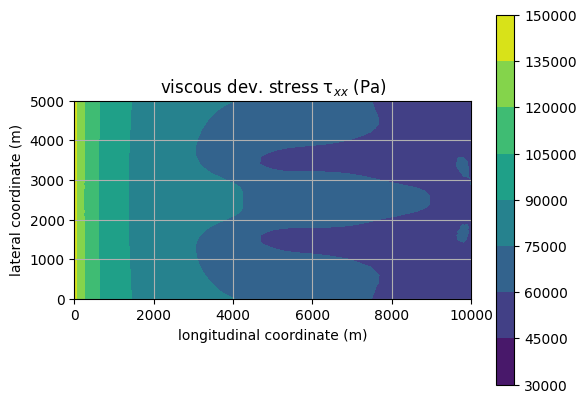

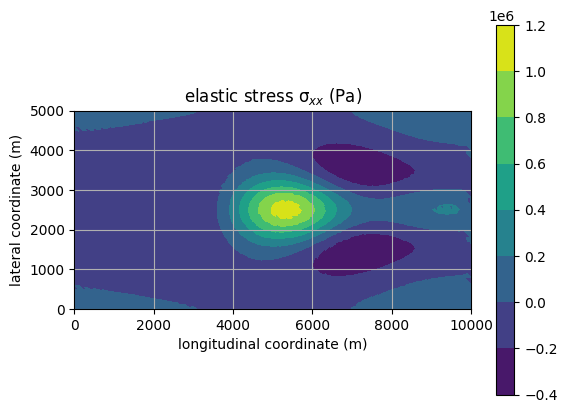

In [8]:
########################
########################
### viscous stresses ###
########################
########################

ε = Function(S)
ε.project(sym(grad(u)))
τ = deviatoric_stress(strain_rate = ε)
τxx = project(τ[0, 0]*1e6, Q2)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('viscous dev. stress τ$_{xx}$ (Pa)')
stress_plot = tricontourf(τxx, axes=ax)
plt.colorbar(stress_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

########################
########################
### elastic stresses ###
########################
########################

σ_surf = -1/2*λ_1*H_*ddη - 1/2*λ_2*H_*tr(ddη)*Identity(2) #stress tensor at the surface (ζ = H/2)
σxx = project(σ_surf[0, 0], Q1)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('elastic stress σ$_{xx}$ (Pa)')
stress_plot = tricontourf(σxx, axes=ax)
plt.colorbar(stress_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

## Which load contributions can we neglect?

Investigate the relative importance of different load contributions in Step 3 (solving the flexure equations). Below, ```f1``` will be the load contribution from the surface mass balance (essentially Eq. 57a and 57c), and ```f2``` will be the load contribution from the velocity field (Eq. 57e). ```f2``` usually ends up being two to three orders of magnitude smaller than ```f1```, so it can probably be safely excluded from the workflow above.

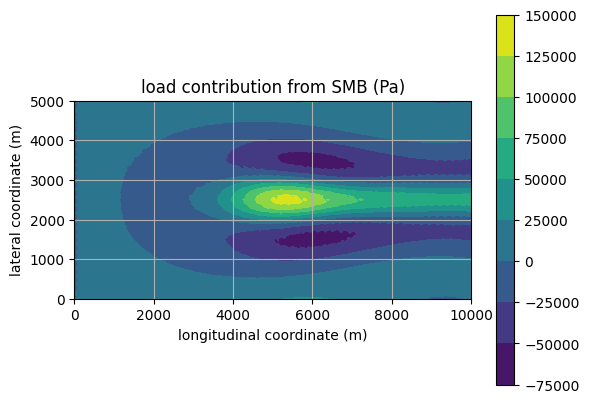

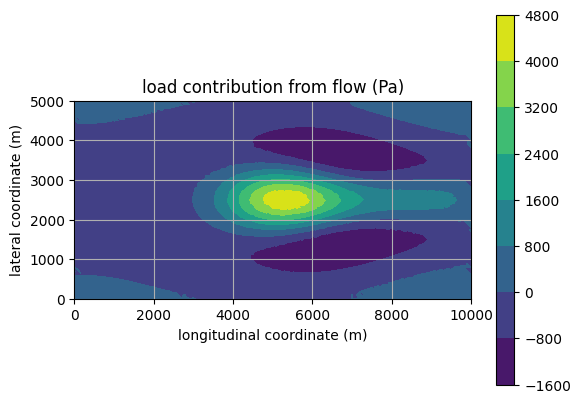

In [9]:
#load contribution from SMB:
f1 = project(conditional(h_ab < 0, -ρ_w*g*h_ab, -ρ_i*g*h_ab), Q1)

#load contribution from flow:
ux, uy = project(u[0], Q1), project(u[1], Q1)
f2 = H_*(4*ν*grad(ux)[0] + 2*ν*grad(uy)[0] - 1/2*ρ_i*g*H_)*ddη[0, 0] #Eq. 57e: ice shelf flow contribution 
f2 += H_*(ν*grad(ux)[1] + ν*grad(uy)[0])*ddη[0, 1] #Eq. 57e continued
f2 += H_*(2*ν*grad(ux)[0] + 4*ν*grad(uy)[1] - 1/2*ρ_i*g*H_)*ddη[1, 1] #Eq. 57e continued
f2 = project(f2, Q1)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('load contribution from SMB (Pa)')
elev_plot = tricontourf(f1, axes=ax)
plt.colorbar(elev_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('load contribution from flow (Pa)')
vel_plot = tricontourf(f2, axes=ax)
plt.colorbar(vel_plot)
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()
plt.show()